<a href="https://colab.research.google.com/github/DavideRutigliano/DataIntelligenceApplication/blob/master/Adverstising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Intelligence Application - Advertising
---------------------------------------------

**Authors:**
* *Davide Rutigliano*

**Project Description**

* Choose a product to advertise by means of digital tools. Provide a brief description.

* Imagine 5 advertising sub-campaigns. Imagine an average daily budget/clicks curve (providing, for every value of daily budget, the number of daily clicks) aggregating the curves of three different classes of users. Notice that, in order to define the curves, it is necessary the definition of probability distributions. Provide a description of the three classes of users. Note: the definition of the classes of the users must be done by introducing features and different values for the features (e.g., gender, interests, age).

* Be given a cumulative daily budget constraint. Be also given a discretisation for the daily budget values. Apply the Combinatorial-GP-TS to the aggregate curve (we are implicitly assuming that the bidding is performed automatically by the advertising platform) and report how the regret varies in time.

* Focus on a single sub-campaign. Report the the average regression error of the GP as the number of samples increases. The regression error is the maximum error among all the possible arms.

* Suppose to apply, the first day of every week, an algorithm to identify contexts and, therefore, to disaggregate the curves if doing that is the best we can do. And, if such an algorithm suggests disaggregating the curve at time t, then, from t on, keep such curves disaggregate. In order to disaggregate the curve, it is necessary to reason on the features and the values of the features. Apply the Combinatorial-GP-TS algorithm and show, in a plot, how the regret and the reward vary in time (also comparing the regret and the reward of these algorithms with those obtained when the algorithms are applied to the aggregate curve).

## Introduction

In this project we focus on the study of pay-per-click advertising, in which an advertiser pays only once a user has clicked an ad. An advertising campaign is characterized by a its subcampaigns each with a (potentially) different pair ad/targeting and by a cumulative daily budget (also called spending plan).

In this type of advertising campaign, the advertiser takes part into an auction specifying a bid and a value for the daily budget for each subcampaign. The goal of advertisers is to select these variables to maximize the expected revenue they get from the advertising campaign.

According to the literature, common methods used to face this problem are the second price auction (GSP) and the Vickrey-Clarke auction (VCG). The proposed method uses combinatorial bandit algorithms techniques to face the problem in an online fashion.

We differentiate customers basing on their class identifyed by the features.

Features are summarized in the following table:

|Feature| Values         |
|-------|:--------------:|
| Age   | {Young, Old}   |
| Nation| {Italy, USA}   |

Each class can occur with a specific probability, in this study we consider:

* 30% of users are from Italy, 70% are from USA;
* 60% customers are young, the remaining 40% are old.

Thus, we have four different probability distribution and disaggregate demand curves, one for each combination of age and gender:

* Italy - Young (18%)
* Italy - Old (12%)
* USA - Young (42%)
* USA - Old (28%)

The probability with which each class can occur is reported in parentesis.

## About the code

We use a function in order to imagine the budget/click curve:

$n(y) = c_{max} \cdot \mathcal{e}^{-\alpha (y - \beta)}$

where $c_{max}$ is the maximum number of clicks, alpha controls how rapidly the click reaches the maximum number of clicks (i.e. the point in which increasing the budget does not increase the number of clicks) and beta is a parameter that controls at which budget the clicks starts increasing (with the meaning that when the bid is too small the ad is not displayed in any auction). The idea is that the curve is zero when the bid is too small, then when starts increasing depends linearly from the budget and from a certain point (budget value) on the dependecy starts to be constant.

In order to obtain differenr curves for different classes we combine different functions defined above (different values of alpha and beta and max no. of clicks).

To get the aggregate curve instead, we combine the base classes curves taking the weighted average on the classes:

$\bar{n}_{j}(y) = \frac {\sum_{k \in F} n_{k,j}(y) . p_{k}} {\sum_{k \in F} p_{k}}, \forall y \in Y_{j}, \forall j \in N$

Where $p_{k}$ is the probability and $n_{k,j}(y)$ is the budget/click curve of class $k \in F$.

In [0]:
import numpy as np
import itertools

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from scipy import stats
from scipy.interpolate import interp1d

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

import pandas as pd

In [0]:
def n(alpha, beta, max_val):
  def f(y):
    return max_val * np.maximum(0, 1 - np.exp(-alpha * (y - beta)))
  return f

def aggregate_function(fun, probabilities):
  def f(budget):
    return np.sum(np.array([fun[k](budget) * probabilities[k] for k in range(len(probabilities))]), axis=0) / np.array(np.sum(probabilities))
  return f

In [0]:
def interpolate(x, y):
  new_x = np.linspace(x.min(), x.max(), 500)
  f = interp1d(x, y, kind='quadratic')
  return new_x, np.maximum(0, np.minimum(y.max(), f(new_x)))

class Context():
  
  def __init__(self, N, budget, value_per_click, features, N_users=1000):
    
    self.N = N
    self.budget = budget
    self.values = value_per_click
    self.features = features
    
    self.alphas = [[[] for f in self.features[fname]] for fname in list(self.features.keys())]
    self.betas = [[[] for f in self.features[fname]] for fname in list(self.features.keys())]
    
    self.C = [[] for i in range(self.N)]
    
    self.n = {}
    for fname in self.features:
      for f in self.features[fname]:
        self.n.update({f : {}})
        
    self.avg_n = [[] for i in range(self.N)]
        
    self.N_users = N_users
    self.data = {}
    for f in self.features:
      self.data.update({f : {}})
      
    self.calculate_clicks()
    
  def calculate_clicks(self):
    
    for fname in list(self.features.keys()):
      for f in list(self.features[fname].keys()):
        
        if f == 'italy':
          max_val = np.linspace(30.0, 75.0, self.N)
        else:
          max_val = np.linspace(15.0, 40.0, self.N)
        if f == 'young':
          max_val = np.linspace(28.0, 33.0, self.N)
        else:
          max_val = np.linspace(35.0, 55.0, self.N)
          
        for j in range(self.N):
          self.alphas = np.random.choice(np.linspace(3, 5, 1000))
          self.betas = np.random.choice(np.linspace(20, 50, 1000))
          self.n[f].update({j : n(self.alphas, self.betas, max_val[j])})
    
    for a, b in list(itertools.combinations(list(self.features.keys()), r=len(list(self.features.keys())))):
      for f1, f2 in list(itertools.product(self.features[a], self.features[b])):
        self.n.update({f1+"-"+f2 : {}})
        for j in range(N):
          self.n[f1+"-"+f2].update({j : aggregate_function(fun=[self.n[f1][j], self.n[f2][j]],
                                          probabilities=[self.features[a][f1], self.features[b][f2]])})
      
    for j in range(N):
      probs = []
      for a, b in list(itertools.combinations(list(self.features.keys()), r=len(list(self.features.keys())))):
        for f1, f2 in list(itertools.product(self.features[a], self.features[b])):
          probs.append(self.features[a][f1] * self.features[b][f2])
      
      fcns = []
      for f in list(self.n.keys()):
        fcns.append(self.n[f][j])
        
      self.avg_n[j] = aggregate_function(fun=fcns, probabilities=probs)
           
  def plot_click_curves(self):

    for f in list(self.n.keys()):
      plt.figure()
      for j in range(N):
        x,y = interpolate(self.budget, self.n[f][j](self.budget))
        plt.plot(x, y, label="C"+str(j+1))
        
      plt.title("Budget/Click Curve, Feature: " + f)
      plt.xlabel("$y$")
      plt.ylabel("$n(y)$")
      plt.legend()
      plt.show()
    
  def plot_aggregate_click_curve(self):
    
    plt.figure()
    for j in range(self.N):
      x, y = interpolate(self.budget, self.avg_n[j](self.budget))
      plt.plot(x, y, label="C"+str(j+1))

    plt.title("Aggregate Budget/Click Curve")
    plt.xlabel("$y$")
    plt.ylabel("$n(y)$")
    plt.legend()
    plt.show()
  
  def sample_users(self, N=None):
   
    sample = {}
    
    for f in self.features:
      sample.update({f : []})
    
    if N == None:
      N = self.N_users
      
    for x in range(N):
      
      for fname in list(self.features.keys()):
        p = np.random.uniform(0,1,1)
        f = list(features[fname].keys())
        
        if p > self.features[fname][f[0]]:
          v = f[1]
        else:
          v = f[0]
        
        sample[fname].append(v)
      
    for f in sample.keys():
      for e in sample[f]:
        self.data[f].append(e)
          
    return self.data
    
  def split(self, mu_c0, p_c1, mu_c1, p_c2, mu_c2):

    if p_c1 * mu_c1 + p_c2 * mu_c2 >= mu_c0:
      return True
    else:
      return False
    
  def update_even_node(self, context, features, p, val):
      
      if len(features) == 0:
        return context
      
      else:
        fname = list(features.keys())[0]
        f = list(features[fname].keys())
        return self.update_odd_node(context, features, fname, f, p, val)
        
  def update_odd_node(self, context, features, fname, f, p, val):
    
    c_val = list(context.values())[0][0]
    if (self.split(c_val, p[f[0]], val[f[0]][0], p[f[1]], val[f[1]][0])):

      if p[f[0]] * val[f[0]][0] >= p[f[1]] * val[f[1]][0]:
        f1 = f[0]
        context = {f1 : val[f[0]]}

      else:
        f1 = f[1]
        context = {f1 : val[f[1]]}
      
    features.pop(fname)

    return self.update_even_node(context, features, p, val)
  
  def split_context(self, B):
          
    total = len(self.data[list(self.features.keys())[0]])

    bound_factor = np.sqrt(-1 * np.math.log(0.95) / (2 * total))
    
    p = {}
    for fname in self.features.keys():
      for f in self.features[fname]:
        p.update({f : self.data[fname].count(f) / np.array(total) - np.array(bound_factor)})
    
    val = {}
    for f in list(self.n.keys()):
      M, A = solve_knapsack(self.N, B, self.budget, [self.n[f][j](self.budget) for j in range(self.N)], self.values)
      opt_budget = [A[j][np.argwhere(M[j] == np.max(M[j]))[0][0]] for j in range(1, self.N+1)]
      opt_arms = [np.where(self.budget == arm)[0][0] for arm in opt_budget]
      opt_val = np.sum([self.values[j] * self.n[f][j](self.budget[opt_arms[j]]) for j in range(N)], axis=0) - np.array(bound_factor)
      val.update({f : [opt_val, opt_arms]})    

    M, A = solve_knapsack(self.N, B, self.budget, [self.avg_n[j](self.budget) for j in range(self.N)], self.values)
    opt_budget = [A[j][np.argwhere(M[j] == np.max(M[j]))[0][0]] for j in range(1, self.N+1)]
    opt_arms = [np.where(self.budget == arm)[0][0] for arm in opt_budget]
    opt_val = np.sum([self.values[j] * self.avg_n[j](self.budget[opt_arms[j]]) for j in range(N)], axis=0) - np.array(bound_factor)
    
    context = {'aggregate' : [opt_val, opt_arms]}

    context = self.update_even_node(context, self.features.copy(), p, val)

    return context

## Formal Model

The model definition is:

* $N$ number of sub campaigns composing the advertising campaing $C$

* $C = \left\{C_{1}, ..., C_{N}\right\}$ advertisign campaign

* $T$ time horizon (expressed in days)

* $t \in T$ time (expressed in days)

* $X_{j}$ bids

* $Y_{j}$ budget

* $B$ spending plan where $B_{j,t}$ is the pair $\left[\underline{y}_{j,t}, \bar{y}_{j,t}\right]$ that are respectively the minimum and maximum cumulative daily budget for campaign $j \in N$ for the day $t \in T$

* $v_{j}$ value per click for subcampaign $j \in N$

* $n_{j}(x_{j}, y_{j})$ number of clicks for subcampaign $j \in N$ given values of bid $x_{j} \in X_{j}$ and budget $y_{j} \in Y_{j}$

In our specific case we run the experiment over a time horizon of $T = 100$ days, with $N = 5$ subcampaigns and linearly spaced values of the budget $y_{j} \in \left[0, 99\right]$ and $|Y_{j}| = 10, \forall j \in N$. Furthermore, we do not take into account of the bids $X_{j}$ because we assume that bidding is automatically performed by the advertising platform (i.e. we assume the bid is costant for each day and for each subcampaign: $x_{j,t} = \bar{x}, \bar{x} \in X_{j}, \forall j \in N, \forall t \in T$); we also assume the values per click $v_{j} = \bar{v} = 1.0$, to be costant for each subcampaign $j \in N$. In addition, we set $\underline{y}_{j,t} = 0$ and $\bar{y}_{j,t} = 99$.

Below budget/click curves are shown (both disaggregate and the aggregate at the end).

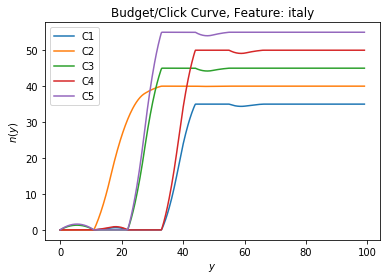

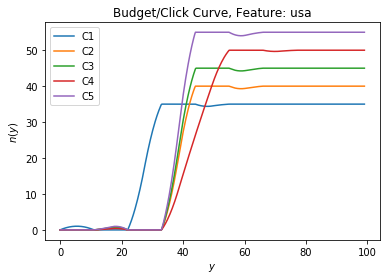

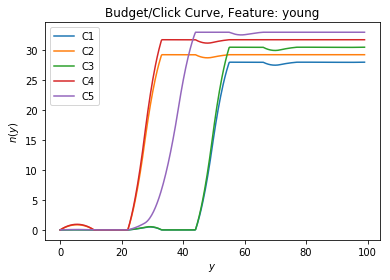

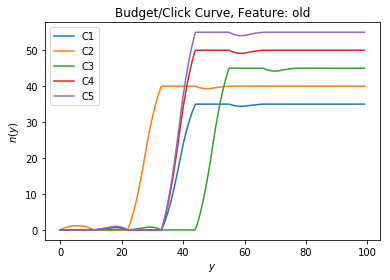

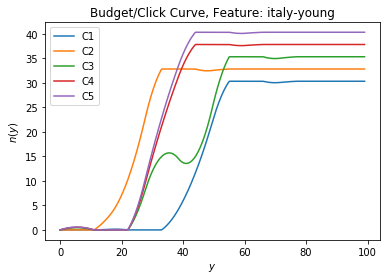

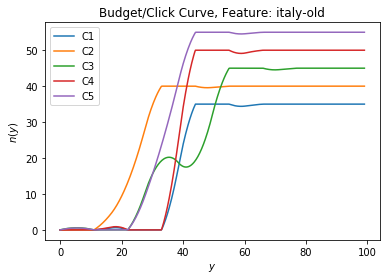

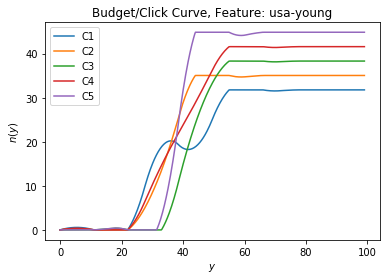

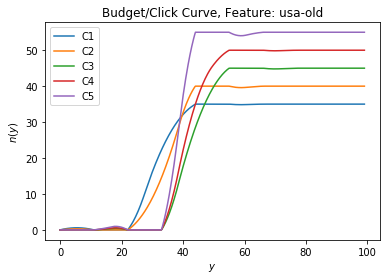

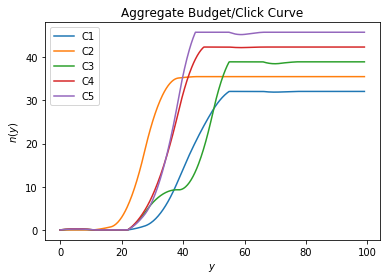

In [4]:
np.random.seed(1234)

N = 5
n_budget = 10

features = {
    "country" : {"italy" : .3,
                 "usa" : .7},
    "age" : {"young" : .6,
             "old" :.4}
}

min_budget, max_budget = 0, 99

budget = np.linspace(min_budget, max_budget, n_budget)
values_per_click = [1.0 for j in range(N)]

context = Context(N, budget, values_per_click, features)
      
context.plot_click_curves()
context.plot_aggregate_click_curve()

## Algorithms

### Multiple Choice Knapsack (MCK) Problem

* **Notation**
  
  $C_{j}: X_{j} \times Y_{j}$ the advertising campaign $j \in N, \forall j \in N$, where $C_{j}(x_{j}, y_{j}) = v_{j}n_{j}(x_{j}, y_{j})$
  
  $M_{j}:$ max number of clicks for each budget $y_{j} \in Y_{j}$ for each subcampaing $j \in N \cup \varnothing$, where the first row of the matrix ($j = 0$) correspond to the initialization of the algorithm with all values set to $0$.

* **Mathematical Formulation**

  Objective Function:

  * $\max_{x_{j,t}, y_{j,t}}{\sum_{j \in N}{v_{j}n_{j}(x_{j,t}, y_{j,t})}}$ 
  
  such that: 
  
  * $\sum_{j \in N}{y_{j,t}} \leq \bar{y}_{t}, \forall t \in T$
  
  * $\underline{x}_{j,t} \leq x_{j,t} \leq \bar{x}_{j,t}, \forall j \in N, \forall t \in T$
  
  * $\underline{y}_{j,y} \leq y_{j,t} \leq \bar{y}_{j,t}, \forall j \in N, \forall t \in T$

* **Algorithm**

  The algorithm takes in input all the advertising campaings $C_{j}$ the sets of bids and budget respectively $X_{j}$ and $Y_{j}$, $\forall j \in N$ and a spending plan $B$.
  
  * For each subcampaign $j \in N$, for each budget $y_{j} \in Y_{j}$ find the bid $x_{j} \in X_{j}$ such that:
    
    $z_{j}(y) = \max_{x_{j} \in X_{j}}{C_{j}(x_{j}, y_{j})}$
    
  * Use the maximum bid found to calculate:
    
    $w_{j}(y) = \begin{cases}
                  v_{j} n_{j}(z_{j}(y), y), &\underline{y}_{j,t} \leq y \leq \bar{y}_{j,t} \\
                  0, &\underline{y}_{j,y} \geq y \vee y \geq \bar{y}_{j,t}
                \end{cases}$
  
  * Compute the value of $M_{j}$ for every budget $y \in Y$:
  
    $M(j,y) = \max_{y' \in Y, y' \leq y}\left\{M(j-1, y') + w_{j}(y - y')\right\}$
    
    At the end of the procedure, the optimal solution of the MCK problem can be found in the cell corresponding to:
    
    $y^* = \max_{y \in Y}{M(N,y)}$
    
    To find the optimal allocation (assignment of the budget), it is sufficient to also store the partial assignments of the budget (i.e. $y - y'$) corresponding to the optimal value.
    
**Note**: In our case, where the bidding is automatically performed by the advertising platform we assume to be already given the number of clicks of the best bid $\bar{x}_{j} \in X_{j}$ for each budget $y_{j} \in Y_{j}$. Thus, the algorithm we implement differ from the one presented above because it skips step 1 of the algorithm as we already have the best bid for each budget.

In [0]:
def solve_knapsack(N, B, budget, clicks, values):
    
  M = np.zeros((N+1, len(budget)), dtype=int)
  A = np.zeros((N+1, len(budget)))
   
  w = [np.zeros((len(budget))) for j in range(N+1)]
  
  for j in range(N):
    
    for t in range(len(budget)):
     
      if (budget[t] >= B[j][0] and budget[t] <= B[j][1]):
        w[j+1][t] = values[j] * clicks[j][t]
      else:
        w[j+1][t] = 0
            
      r = []
      s = []

      for k in range(t+1)[::-1]:       
        r.append(M[j][k] + w[j+1][t-k])
        s.append(budget[t] - budget[k])

      k = np.argmax(r)
      M[j+1][t] = r[k]
      A[j+1][t] = s[k]
    
  return M, A

In [6]:
B = [[min_budget, max_budget] for j in range(N)]

M, A = solve_knapsack(N, B, budget, [context.avg_n[j](budget) for j in range(N)], values_per_click)

pd.DataFrame(M,
             index=pd.Index(["C"+str(i) for i in range(N+1)]),
             columns=[budget[i] for i in range(len(budget))])

,0.0,11.0,22.0,33.0,44.0,55.0,66.0,77.0,88.0,99.0
C0,0,0,0,0,0,0,0,0,0,0
C1,0,0,0,4,20,32,32,32,32,32
C2,0,0,5,30,35,35,35,50,62,67
C3,0,0,5,30,35,38,38,50,68,73
C4,0,0,5,30,39,42,44,69,74,77
C5,0,0,5,30,45,45,50,75,84,87


In [7]:
opt_true_val = np.max(M)
print("Optimal Solution:", str(opt_true_val))
opt_true_budget = [A[j][np.argwhere(M[j] == np.max(M[j]))[0][0]] for j in range(1, N+1)]
opt_true_arms = [np.where(budget == arm)[0][0] for arm in opt_true_budget]
print("Best Arms:", opt_true_arms + np.array(1))

Optimal Solution: 87
Best Arms: [6 5 6 5 5]


### Environment and Learner

The Environment is aimed at simulating the single experiment by returning a reward $r \sim \mathcal{N}(n(y), 10)$ with the meaning of clicking/not-clicking once the user have seen the ad.

The Learner class is a common class for bandits aimed at collecting the rewards and the arms pulled at each round.

In [0]:
class Bidding_Environment():
  
  def __init__ (self, budget, mean, sigma):
    
    self.std_dev = sigma
    self.budget = budget
    self.means = mean(self.budget)
    self.sigmas = np.ones(len(self.budget)) * self.std_dev
        
  def round(self, pulled_arm):
    return np.random.normal(self.means[pulled_arm], self.sigmas[pulled_arm])
  
class Learner():
  
  def __init__(self, n_arms, arms):
    
    self.n_arms = n_arms
    self.arms = arms    
    self.t = 0
    self.rewards = []
    self.arm_pulled = []

  def update_observation(self, pulled_arm, reward):
    
    self.rewards.append(reward)
    self.arm_pulled.append(pulled_arm)

### Gaussian Process Thompson Sampling

* **Notation**

  $\mathbb P(\mu_{a}=\theta_{a})$ prior of the expected value of $X_{a}$
  
  $\theta_{a}$ variable of $\mathbb P(\mu_{a}=\theta_{a})$
  
  $(\mu_{a_{t}}, \sigma_{a_{t}})$ parameters of the normal distribution $P(\mu_{a}=\theta_{a})$
  
* **Gaussian Process**

  The parameters that define a gaussian process are:

  $m: Y_{j} \rightarrow \mathbb{R}$ its mean

  $k: Y_{j} \times Y_{j} \rightarrow \mathbb{R}$ its covariance matrix

  If we don't have any prior information we set $m(y) = 0$, otherwise we can model the mean of the gaussian process in order to include the prior informations about the model.

  The covariance function $k(y,y') = \mathbb{E}\left[(f(y)- m(y)) \cdot (f(y')- m(y'))\right]$,

  We decided to use a squared exponential kernel, that is:

  $k(y,y') = \theta^2\mathcal{e}^{-\frac{(y-y')^2}{2l^2}}$ where $\theta$ is the scale factor and $l$ is the length-scale, using initial values for $\theta=1$ and $l=1$ (common choice when no prior knowledge on the process is available). Furthermore we add a noise to the process, setting initially its variance to $\sigma_{n} = 10$.

  We use a gaussian process defined as above in order to estimate the budget/click curve:

  $n(y) = \mathcal{GP}(m(y), k(y,\cdot)), \forall y \in Y_{j}$

* **Pseudocode**

  For each day $t \in T$, do:
  
  * For each subcampaign $j \in N$:
  
* *Pseudocode*

  * At every time $t$:
    
    * For every arm $a$:
  
      $\tilde{\theta_{a}} \leftarrow Sample(\mathbb P(\mu_{a}=\theta_{a}))$
  
      $a_{t} \leftarrow \DeclareMathOperator*{\argmax}{arg\,max}
  \argmax_a \left\{ \tilde{\theta_{a}} \right\} $

      $n_{j}(y) \leftarrow Sampling(\mathbf{a})$

  * $\left\{\hat{y}_{j,t}\right\}_{j \in N} \leftarrow Optimize(\left\{(v_{j}, n_{j}(y), Y_{j}\right\}_{j \in N}, \bar{y}_{t})$
      
The algorithm works in the following way: the first step for each day for each arm we choose the best arm according to Thompson Sampling selection criterion, then use the arms pulled and rewards obtained so far to estimate (by meaning of Bandit algorithms, GP-TS in our case, for each subcampaing) the budget/click curve $n_{j}(y)$. Then, for each day the optimal solution for each subcampaign can be found by solving the Multiple-Choice Knapsack problem with the procedure described above.

In [0]:
class GPTS_learner(Learner):
    
  def __init__(self, n_arms, arms, sigma, lenght_scale, scale_factor):
    
    super().__init__(n_arms=n_arms, arms=arms)
    
    self.std_dev = sigma
    self.means = np.zeros((n_arms))
    self.sigmas = np.ones((n_arms)) * 1e-2
    self.theta = lenght_scale
    self.l = scale_factor
    
    kernel = ConstantKernel(self.theta ,(1e-3, 1e3)) * RBF(self.l, (1e-2, 1e2))
    
    self.gp = GaussianProcessRegressor(kernel=kernel, alpha=self.std_dev**2,
                                       normalize_y=True,
                                       n_restarts_optimizer=9)
    
  def pull_arm(self):

    idx = np.argmax(np.random.normal(self.means, self.sigmas))
    return idx  
    
  def update_model(self):

    x = np.atleast_2d(self.arms[self.arm_pulled]).T
    y = self.rewards + np.array(np.random.normal(0, self.std_dev))

    self.gp.fit(x, y)

    self.means, self.sigmas = self.gp.predict(np.atleast_2d(self.arms).T,
                                              return_std=True)
    
    self.sigmas = np.maximum(self.sigmas, 1e-2)
    
  def update(self, pulled_arm, reward):
    
    self.t += 1
    self.update_observation(pulled_arm, reward)
    self.update_model()

## Results

We run for each algorithm 100 indipendent experiments and then average the results.

Given a policy $\mathfrak{U}$, we define the instantaneous reward and regret as the difference between the optimal candidate (clairvoyant solution) and the expected value of the reward given by the MAB:

* $\mathbb{E}\left[\sum_{j=1}^{N}{v_{j} n_{j}(\hat{y}_{j})}\right]$
* $R_{t}\left(\mathfrak{U}\right) = T G^* - \mathbb{E}\left[\sum_{j=1}^{N}{v_{j} n_{j}(\hat{y}_{j})}\right]$

And cumulative (or pseudo-) reward and regret, respectively:

* $\mathbb{E}\left[\sum_{j=1}^{N}{\sum_{t=1}^{T}{v_{j} n_{j}(\hat{y}_{j})}}\right]$
* $R_{T}\left(\mathfrak{U}\right) = T G^* - \mathbb{E}\left[\sum_{j=1}^{N}{\sum_{t=1}^{T}{v_{j} n_{j}(\hat{y}_{j})}}\right]$

Where $G^* = \sum_{j=1}^{N}{v_{j}^* n_{j}(y_{j}^*)}$ is the (optimal) value provided by the clairvoyant algorithm.

We show here results, after the execution of each algorithm, in 4 different plots respectively:

* Instantaneous Reward vs. Clayrvoiant
* Instantaneous Regret
* Cumulative Reward vs. Clayrvoiant
* Cumulative Regret

We also plot data points, target and estimated functions for each subcampaign.

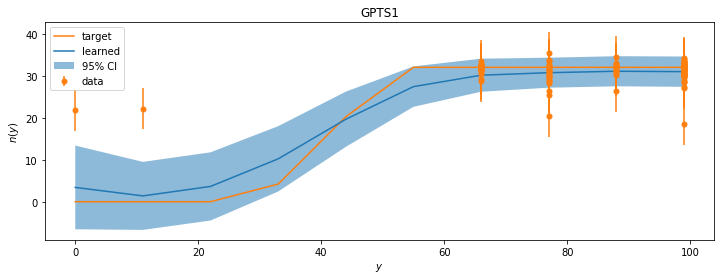

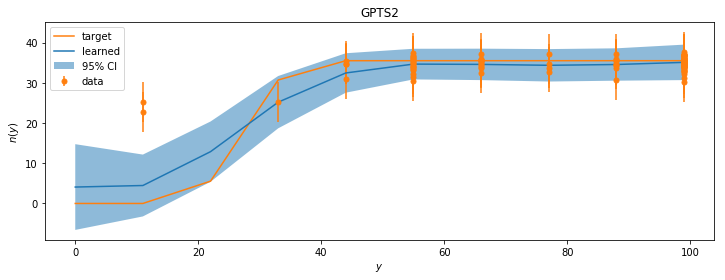

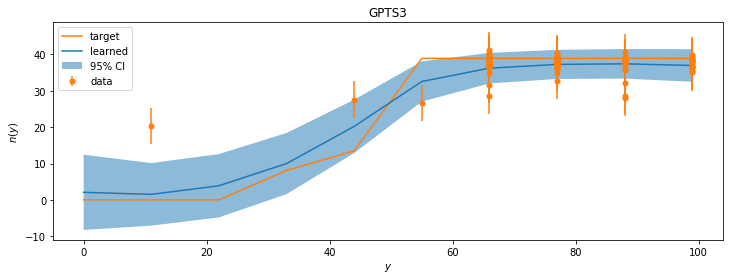

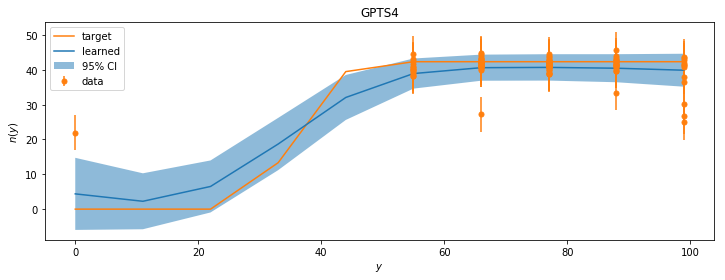

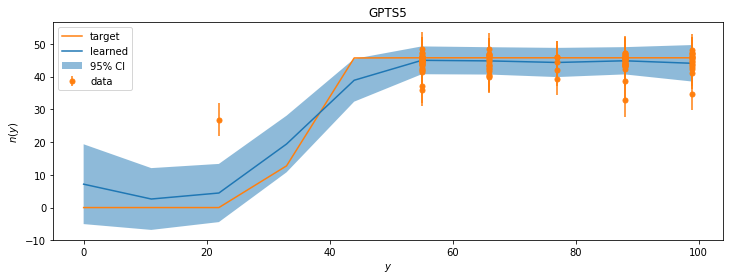

In [10]:
np.random.seed(1234)

T = 100
n_experiments = 20

rewards = [[] for j in range(N)]
arms = [[] for j in range(N)]

means = [[] for j in range(N)]
sigmas = [[] for j in range(N)]

M = np.zeros((n_experiments, N+1, n_budget), dtype=int)
A = np.zeros((n_experiments, N+1, n_budget))
B = [[min_budget, max_budget] for j in range(N)]
theta, l = 1, 1
noise_std = 5.0
reg_error = np.zeros((n_experiments, N, T))

for exp in range(n_experiments):
  learners = [GPTS_learner(len(budget), budget, noise_std, theta, l) for j in range(N)]
  envs = [Bidding_Environment(budget=budget, mean=context.avg_n[j], sigma=noise_std) for j in range(N)]

  best_arms = np.zeros((T, N), dtype=int)
  
  for t in range(T):
    for j in range(N):
            
      arm_pulled = learners[j].pull_arm()
        
      reward = envs[j].round(arm_pulled)
      learners[j].update(arm_pulled, reward)
            
      arms[j].append(learners[j].arm_pulled)
      rewards[j].append(learners[j].rewards)
      
      means[j].append(learners[j].means)
      sigmas[j].append(learners[j].sigmas)
      
      reg_error[exp][j][t] = np.max(np.array((learners[j].means - envs[j].means)**2).mean())
            
    M[exp], A[exp] = solve_knapsack(N, B, budget, [learners[j].means for j in range(N)], values_per_click)
    opt_budget = [A[exp][j][np.argwhere(M[exp][j] == np.max(M[exp][j]))[0][0]] for j in range(1, N+1)]
    best_arms[t] = [np.where(budget == arm)[0][0] for arm in opt_budget]

for j in range(N):
  plt.figure(figsize=(12,4))

  plt.plot(np.atleast_2d(budget).T, envs[j].means, label="target", color="C1")

  plt.plot(np.atleast_2d(budget).T, np.mean(means, axis=1)[j], label="learned", color="C0")

  plt.fill(np.concatenate([np.atleast_2d(budget).T , np.atleast_2d(budget).T[::-1]]),
              np.concatenate([np.mean(means, axis=1)[j] + 1.96*np.mean(sigmas, axis=1)[j],
                            (np.mean(means, axis=1)[j] - 1.96*np.mean(sigmas, axis=1)[j])[::-1]]),
              alpha=0.5, ec=None, label="95% CI")

  plt.errorbar(np.atleast_2d([budget[a] for a in stats.mode(arms, axis=1)[0][j].reshape(T)]).T,
               np.mean(rewards, axis=1)[j],
               noise_std, fmt='C1.', markersize=10, label='data')
  
  plt.title("GPTS"+str(j+1))
  plt.xlabel('$y$')
  plt.ylabel('$n(y)$')
  plt.legend()

  plt.show()

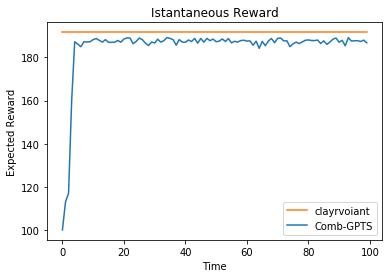

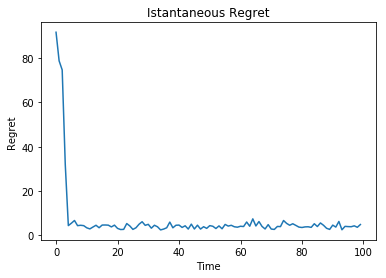

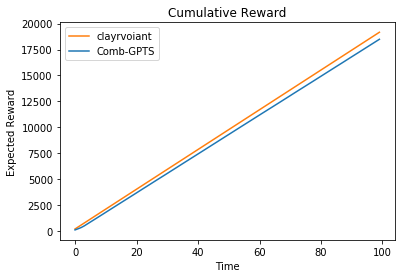

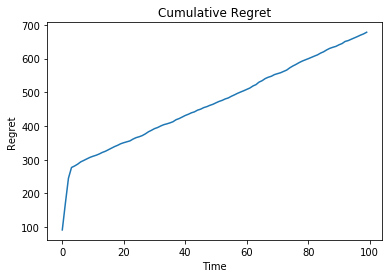

In [11]:
clairvoyant = np.sum([values_per_click[j] * envs[j].means[opt_true_arms[j]] for j in range(N)], axis=0)

estimated = [[] for j in range(N)]
for j in range(N):
  pulled = stats.mode(arms, axis=1)[0][j].reshape(T)
  for t in range(T):
    estimated[j].append(values_per_click[j] * np.mean(means, axis=1)[j][pulled[t]])

reward = np.sum(np.array(estimated), axis=0)

plt.figure()
plt.title("Istantaneous Reward")
plt.plot(range(T), T * [clairvoyant], label='clayrvoiant', color="C1")
plt.plot(range(T), reward, label='Comb-GPTS', color="C0")
plt.xlabel("Time")
plt.ylabel("Expected Reward")
plt.legend()
plt.show()

plt.figure()
plt.title("Istantaneous Regret")
plt.plot(range(T), T * [clairvoyant] - reward)
plt.xlabel("Time")
plt.ylabel("Regret")
plt.show()

plt.figure()
plt.title("Cumulative Reward")
plt.plot(range(T), np.cumsum(T * [clairvoyant]), label='clayrvoiant', color="C1")
plt.plot(range(T), np.cumsum(reward), label='Comb-GPTS', color="C0")
plt.xlabel("Time")
plt.ylabel("Expected Reward")
plt.legend()
plt.show()

plt.figure()
plt.title("Cumulative Regret")
plt.plot(range(T), np.cumsum(T * [clairvoyant] - reward))
plt.xlabel("Time")
plt.ylabel("Regret")
plt.show()

### Regression Error

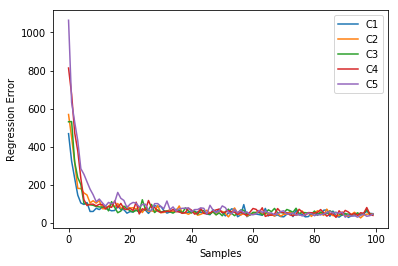

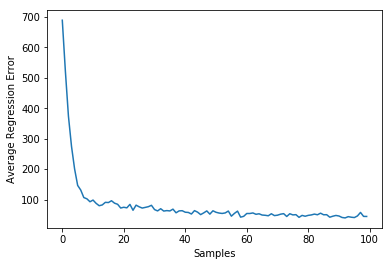

In [12]:
plt.figure()
for j in range(0, N):
  plt.plot(range(T), np.mean(reg_error, axis=0)[j], label="C"+str(j+1))
plt.xlabel("Samples")
plt.ylabel("Regression Error")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(T), np.mean(np.mean(reg_error, axis=0),axis=0))
plt.xlabel("Samples")
plt.ylabel("Average Regression Error")
plt.show()

### Optimization

In [13]:
pd.DataFrame(np.mean(M, axis=0, dtype=int),
             index=pd.Index(["C"+str(i) for i in range(N+1)]),
             columns=[budget[i] for i in range(len(budget))])

,0.0,11.0,22.0,33.0,44.0,55.0,66.0,77.0,88.0,99.0
C0,0,0,0,0,0,0,0,0,0,0
C1,3,5,7,11,21,29,31,32,33,33
C2,4,8,17,29,38,41,43,48,56,63
C3,3,8,15,28,37,41,45,52,61,70
C4,6,11,19,31,42,48,54,64,72,80
C5,10,15,22,36,49,55,62,73,83,90


In [14]:
print("Optimal Solution (found/optimal):", str(np.max(np.mean(M, axis=0, dtype=int))), "/", opt_true_val)
opt_est_budget = np.array([stats.mode(A, axis=0)[0].reshape(N+1, n_budget)[j][np.argwhere(np.mean(M, axis=0)[j] == np.max(np.mean(M, axis=0)[j]))[0][0]] for j in range(1, N+1)]).reshape(N)
opt_est_arms = [np.where(budget == arm)[0][0] for arm in opt_est_budget]
print("Best Arms:", "found:", opt_est_arms + np.array(1), ", optimal:", opt_true_arms + np.array(1))

Optimal Solution (found/optimal): 90 / 87
Best Arms: found: [9 5 6 6 5] , optimal: [6 5 6 5 5]


## Context Generation

* Notation

  $t$ time

  $l$ features, we assume each feature can have a binary value (e.g. for feature young, we have that a customer is either young or not)

  $F \subseteq \left\{0,1\right\}^l$ space of attributes

  $c \subseteq F$ context

  $\mathscr{P} = \left\{c : c \subseteq F, c \cup \varnothing, c \cap F\right\}$ context structure

  **Value of a context structure:**
  
  $J_{c}^*(y) = \sum_{j=1}^{N}{v_{j}^* n(y_{j}^*)}$
  
  (where $J_{c}$ is the objective function of the MCK problem)
  
  $v = \sum_{c \in \mathscr{P}}{p_{c} J_{c}^*(y)}$

  **Split condition:**

  $\underline{p}_{c_{1}} \underline{J}_{c_{1}}^*(y)+\underline{p}_{c_{2}} \underline{J}_{c_{2}}^*(y) \geq \underline{J}_{c_{0}}^*(y)$

  Where:
  
  $\underline{p}_{c_{i}}$ is the lower bound of the probability of context $c_{i}$ and,
  
  $\underline{J}_{c}^*(y)$ is the lower bound of the (optimal) objective function of the MCK problem defined before in context $c_{i}$:
  
  $\underline{J}_{c}^*(y) = \sum_{j=1}^{N}{\underline{v}_{j}^* \underline{n}(y_{j}^*)}$
  
  **Lower bound:**

  The lower bound is calculated as the Hoeffding bound, that for Bernoulli distribution is:

  $\bar{x} - \sqrt{-\frac{log(\delta)}{2\mid Z\mid}}$

  where $\delta$ is the confidence and $Z$ is the dataset


* Algorithm
  
  * For every feature:
    
    * Split the context $c$ (according to the split condition defined before) if it's worth doing it
    
    * Evaluate the value $v$ of the context after the split
  
  * Select the feature with the highest value $v$ if larger than the non split case

In [15]:
context.N_users = 100
context.data = {'country' : [], 'age' : []}
np.random.seed(1234)
      
context_data = context.sample_users()

pd.DataFrame(context_data, index=pd.Index("User " + str(i+1) for i in range(len(context.data["country"])))).head()

,country,age
User 1,italy,old
User 2,usa,old
User 3,usa,young
User 4,italy,old
User 5,usa,old


In [16]:
context_summary = pd.DataFrame(context_data).pivot_table(values=['country','age'], index=['country','age'], aggfunc=lambda x: len(x))

pd.DataFrame(context_summary, columns=['#customers'])

#customers
country age              
italy   old            13
        young          13
usa     old            35
        young          39

In [17]:
context_value = context.split_context(B)
context_value

{'usa': [224.7093465837183, [4, 5, 4, 5, 4]]}

## Results

We decided to apply the context generation algorithm each week, supposing we have 100 customers per day.

In [18]:
np.random.seed(1234)

customers_per_day = 100

r = {"basic-Comb-GPTS" : reward}

T = 100
n_experiments = 20

clairvoyant = np.zeros((n_experiments, T))

rewards = [[] for j in range(N)]
arms = [[] for j in range(N)]

means = [[] for j in range(N)]
sigmas = [[] for j in range(N)]

reg_error = np.zeros((n_experiments, N, T))

M = np.zeros((n_experiments, N+1, n_budget), dtype=int)
A = np.zeros((n_experiments, N+1, n_budget))
B = [[min_budget, max_budget] for j in range(N)]
theta, l = 1, 1
noise_std = 5.0

for exp in range(n_experiments):
  
  context.data = {'country' : [], 'age' : []}
  
  if exp == 0:
    verbose = True
  else:
    verbose = False
    
  learners = [GPTS_learner(len(budget), budget, noise_std, theta, l) for j in range(N)]
  envs = [Bidding_Environment(budget=budget, mean=context.avg_n[j], sigma=noise_std) for j in range(N)]

  best_arms = np.zeros((T, N), dtype=int)
  old_context = None
  
  for t in range(T):
    for j in range(N):
            
      #italy = np.random.choice(np.linspace(0, 1, 1000))
      #usa = 1 - italy
      #young = np.random.choice(np.linspace(0, 1, 1000))
      #old = 1 - young
      #context.features["country"] = {'italy' : italy, 'usa' : usa}
      #context.features["age"] = {'young' : young, 'old' : old}

      context.sample_users(N=customers_per_day)

      if t % 7 == 0:

        ctx = context.split_context(B)
        context_value = list(ctx.keys())[0]

        if context_value != old_context and verbose:
          if old_context != None:
            print("Context switch in week:", int(t/context.N) + 1, "from", old_context, "to", context_value,
                  "\n(time: %d, total customers = %d: ita = %d, usa = %d, young = %d, old = %d)" % (t + 1, len(context.data["country"]),
                                                                                         context.data["country"].count("italy"),
                                                                                         context.data["country"].count("usa"),
                                                                                         context.data["age"].count("young"),
                                                                                         context.data["age"].count("old")), "\n")
          else:
            print("Initial context:", context_value, "\n")

          old_context = context_value

      if context_value == 'aggregate':
        envs[j].means = context.avg_n[j](budget)

      else:
        envs[j].means = context.n[context_value][j](budget)
      
      arm_pulled = learners[j].pull_arm()

      reward = envs[j].round(arm_pulled)
      learners[j].update(arm_pulled, reward)

      arms[j].append(learners[j].arm_pulled)
      rewards[j].append(learners[j].rewards)

      means[j].append(learners[j].means)
      sigmas[j].append(learners[j].sigmas)

      reg_error[exp][j][t] = np.max(learners[j].sigmas)
      clairvoyant[exp][t] += values_per_click[j] * envs[j].means[ctx[context_value][1][j]]
      
    M[exp], A[exp] = solve_knapsack(N, B, budget, [learners[j].means for j in range(N)], values_per_click)
    opt_budget = [A[exp][j][np.argwhere(M[exp][j] == np.max(M[exp][j]))[0][0]] for j in range(1, N+1)]
    best_arms[t] = [np.where(budget == arm)[0][0] for arm in opt_budget]

Initial context: usa 



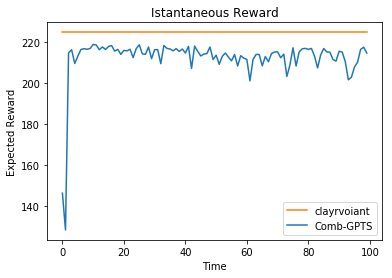

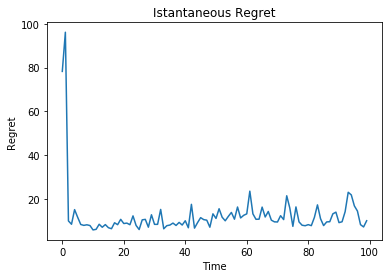

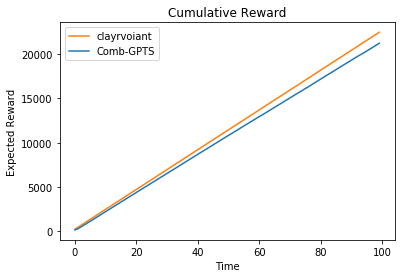

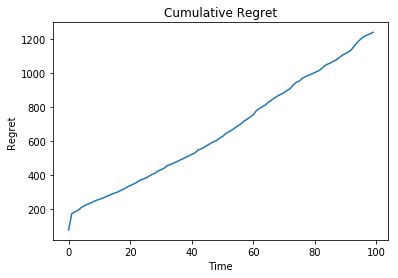

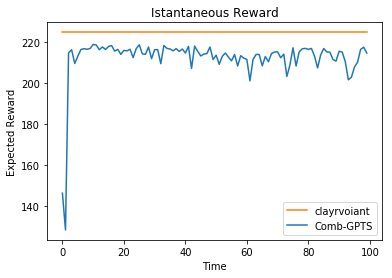

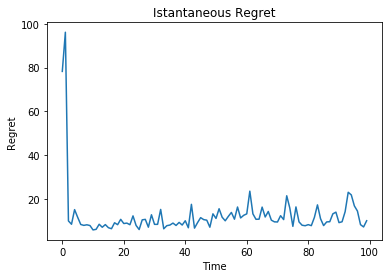

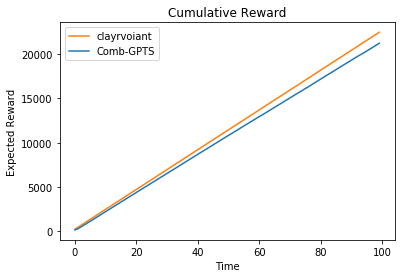

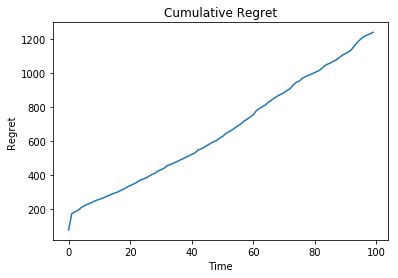

In [19]:
estimated = [[] for j in range(N)]
for j in range(N):
  pulled = stats.mode(arms, axis=1)[0][j].reshape(T)
  for t in range(T):
    estimated[j].append(values_per_click[j] * np.mean(means, axis=1)[j][pulled[t]])

reward = np.sum(np.array(estimated), axis=0)

r.update({"contextual-Comb-GPTS" : reward})

plt.figure()
plt.title("Istantaneous Reward")
plt.plot(range(T), np.mean(clairvoyant, axis=0), label='clayrvoiant', color="C1")
plt.plot(range(T), reward, label='Comb-GPTS', color="C0")
plt.xlabel("Time")
plt.ylabel("Expected Reward")
plt.legend()
plt.show()

plt.figure()
plt.title("Istantaneous Regret")
plt.plot(range(T), np.mean(clairvoyant, axis=0) - reward)
plt.xlabel("Time")
plt.ylabel("Regret")
plt.show()

plt.figure()
plt.title("Cumulative Reward")
plt.plot(range(T), np.cumsum(np.mean(clairvoyant, axis=0)), label='clayrvoiant', color="C1")
plt.plot(range(T), np.cumsum(reward), label='Comb-GPTS', color="C0")
plt.xlabel("Time")
plt.ylabel("Expected Reward")
plt.legend()
plt.show()

plt.figure()
plt.title("Cumulative Regret")
plt.plot(range(T), np.cumsum(np.mean(clairvoyant, axis=0) - reward))
plt.xlabel("Time")
plt.ylabel("Regret")
plt.show()

### Comparison with the results of non contextual versions


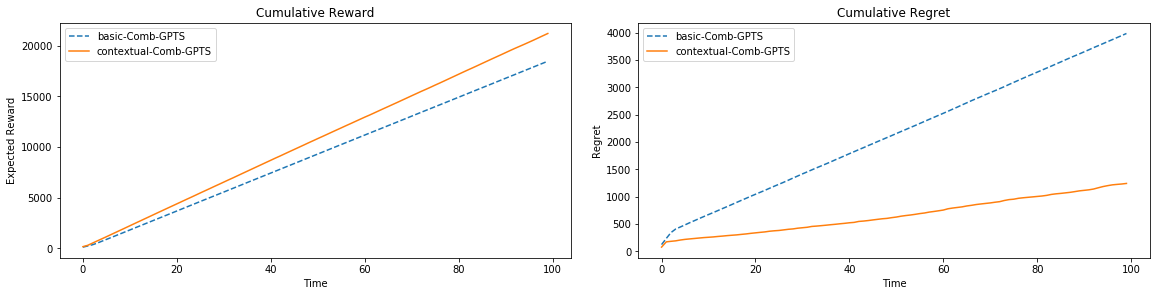

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16,4), constrained_layout=True)

for version in list(r.keys()):
  
  if version == "basic-Comb-GPTS":
    fmt = '--'
  else:
    fmt = '-'
      
  ax[0].plot(range(T), np.cumsum(r[version]), fmt, label=version)

ax[0].set_title("Cumulative Reward")
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Expected Reward')
ax[0].legend()

for version in list(r.keys()):
  
  if version == "basic-Comb-GPTS":
    fmt = '--'
  else:
    fmt = '-'
  
  ax[1].plot(range(T), np.cumsum(np.mean(clairvoyant, axis=0) - np.array(r[version])), fmt, label=version)

ax[1].set_title("Cumulative Regret")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Regret')
ax[1].legend()

plt.show()